In [288]:
import os
import zipfile as zf
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import keras
import cv2
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
import itertools
import psycopg2
from psycopg2 import OperationalError

In [235]:
files = zf.ZipFile(r"C:\Users\batuh\Desktop\MangoLeafDisease.zip", 'r')
files.extractall('Mango Folder')
files.close()

In [236]:
def create_dataset(data_dir):
    filepaths = []
    labels = []
    class_names = os.listdir(data_dir)
    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        for image_file in os.listdir(class_dir):
            # .ipynb_checkpoints gibi özel dosyaları atlayın
            if image_file.startswith('.'):
                continue
            filepaths.append(os.path.join(class_dir, image_file))
            labels.append(class_name)
    return filepaths, labels

# Veri setini oluştur
data_dir = r'C:\Users\batuh\ESEN_ML/Mango Folder/MangoLeafBD Dataset'
filepaths, labels = create_dataset(data_dir)

# Dosya yollarını ve etiketleri DataFrame'e dönüştür
data = pd.DataFrame({'filepath': filepaths, 'label': labels})


In [237]:
df = data.copy()

In [ ]:
df['label'] = df['label'].apply(lambda x: 0 if x == 'Healthy' else 1)


In [ ]:
df.label.value_counts()

In [ ]:
df.head()

In [152]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
from PIL import Image
import os
from tqdm import tqdm

def load_images_from_folders(folders):
    images = []
    for folder in folders:
        for filename in tqdm(os.listdir(folder)):
            if filename.endswith('.jpg') or filename.endswith('.png'):
                img = Image.open(os.path.join(folder, filename))
                img = img.resize((256, 256))  # Resmi yeniden boyutlandır
                img = np.array(img)
                images.append(img.flatten())
    return images

# Ana klasör yolu
main_folder_path = r'C:\Users\batuh\ESEN_ML/Mango Folder/MangoLeafBD Dataset'  # Ana klasör yolu, yüklenen resimle aynı yolu kullandığınızı varsayıyorum

# Sağlıklı ve sağlıksız yaprak resimlerinin klasör yolları
healthy_folder = os.path.join(main_folder_path, 'Healthy')
unhealthy_folders = [os.path.join(main_folder_path, folder_name) for folder_name in [
    'Anthracnose', 'Bacterial Canker', 'Cutting Weevil', 'Die Back', 
    'Gall Midge', 'Powdery Mildew', 'Sooty Mould'
]]

# Resimleri yükle
healthy_images = load_images_from_folders([healthy_folder])
unhealthy_images = load_images_from_folders(unhealthy_folders)



# Her iki kategoriden gelen resimlerin birleştirilmesi
all_images = np.array(healthy_images + unhealthy_images)

healthy_labels = [0] * len(healthy_images)  # Sağlıklı yapraklar için 0
unhealthy_labels = [1] * len(unhealthy_images)  # Sağlıksız yapraklar için 1
all_labels = np.array(healthy_labels + unhealthy_labels)

# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=0.2, random_state=42,stratify=all_labels)

# PCA ile boyut indirgeme (isteğe bağlı)
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# KMeans kümeleme
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(X_train_pca)

train_clusters = kmeans.predict(X_train_pca)
test_clusters = kmeans.predict(X_test_pca)



100%|██████████| 500/500 [00:01<00:00, 367.26it/s]
C:\Users\Batuhan\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [153]:
print("Eğitim seti küme etiketleri:", train_clusters)
print("Test seti küme etiketleri:", test_clusters)

Eğitim seti küme etiketleri: [1 1 1 ... 0 1 1]
Test seti küme etiketleri: [0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 0 0 1 1 0 1 0 0 0 0 1 0 1 1 0 1 0 1 0
 1 1 0 1 0 1 1 0 0 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1
 1 1 0 1 0 0 0 1 1 1 1 0 0 1 0 1 0 1 0 1 1 0 0 1 1 1 0 1 0 1 1 0 1 1 1 0 0
 1 1 1 1 1 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 0 1 1 1 1 1 0 1
 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 0 0 1 0 0 0 1 1 1 0 0 1 0
 0 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 0 0 1 1 1 1 1 0 1 0 1 0 0 1 0 0 1 1 1 1 1
 0 0 1 1 0 1 1 1 1 0 0 1 0 1 0 0 0 1 0 1 1 0 1 0 0 1 0 0 1 1 0 1 1 1 1 0 1
 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 0 1 0 1 0 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 0 0 1 0 1 0 0 1 0 1 0 0
 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 0 1 1 1 1 0 0 1 0 0 1 0 0 1 0 1 0 1 0 0 1 0
 0 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 0 1 0 1 1 0 1 1 0 1 1 1 1 0 0 0 0 1 1
 0 1 0 0 1 0 1 1 1 1 0 1 1

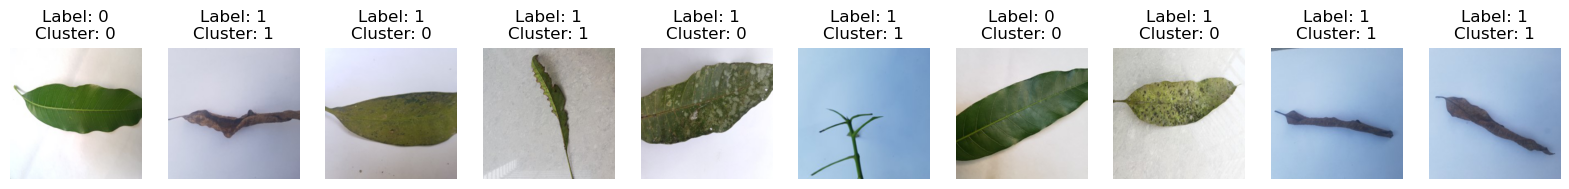

In [161]:
import matplotlib.pyplot as plt
import random

def plot_images_with_clusters(images, labels, clusters, num_samples=20):
    # Rastgele num_samples sayıda resim ve etiket seç
    indices = random.sample(range(len(images)), num_samples)
    selected_images = [images[i] for i in indices]
    selected_labels = [labels[i] for i in indices]
    selected_clusters = [clusters[i] for i in indices]

    # Görselleştirme
    fig, axs = plt.subplots(1, num_samples, figsize=(20, 2))
    for i, (image, label, cluster) in enumerate(zip(selected_images, selected_labels, selected_clusters)):
        axs[i].imshow(image.reshape(256, 256, 3))  # Resmi orijinal boyutuna döndür
        axs[i].set_title(f"Label: {label}\nCluster: {cluster}")
        axs[i].axis('off')

    plt.show()

# Test veri setinden rastgele 10 resmi ve onların küme etiketlerini görselleştir
plot_images_with_clusters(X_test, y_test, test_clusters, num_samples=10)


In [408]:
cmkmeans = confusion_matrix(y_test,test_clusters)

In [413]:
cmkmeans

array([[ 63,  37],
       [199, 501]], dtype=int64)

In [164]:
precision_score(y_test, test_clusters)

0.9312267657992565

In [165]:
accuracy_score(y_test, test_clusters)

0.705

In [166]:
recall_score(y_test, test_clusters)

0.7157142857142857

Text(0.5, 23.52222222222222, 'predicted label')

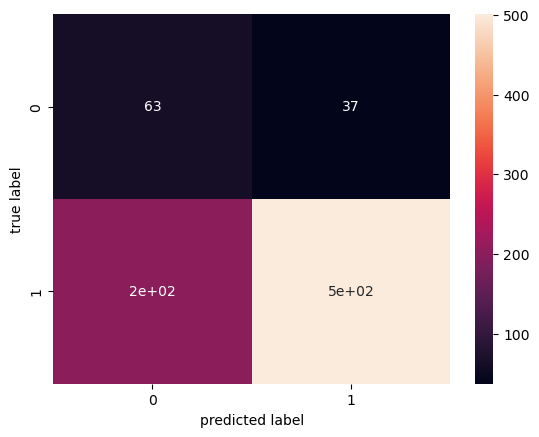

In [168]:
mat = confusion_matrix(y_test,test_clusters)
sns.heatmap(mat, annot=True)
plt.ylabel('true label')
plt.xlabel('predicted label')

In [239]:
df.label.value_counts()

Anthracnose         500
Bacterial Canker    500
Cutting Weevil      500
Die Back            500
Gall Midge          500
Healthy             500
Powdery Mildew      500
Sooty Mould         500
Name: label, dtype: int64

# Inception v3

In [176]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras import regularizers

In [177]:
img_dir = r'C:\Users\batuh\ESEN_ML/Mango Folder/MangoLeafBD Dataset'
data = tf.keras.preprocessing.image_dataset_from_directory(img_dir)

Found 4002 files belonging to 8 classes.


In [240]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.7, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123)

In [254]:
batch_size = 64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

#Test veri setinin üzerinde modelin tahminlerini değerlendirmek üzere uygun bir batch_size ve adım sayısını belirlemek amacıyla kullanılmıştır.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size


# Undefined hatası almamak için tanımlanıyor scalar fonksiyonu.
# scalar:her bir görüntü üzerinde uygulanacak olan özel bir ölçekleme (scaling) fonksiyonunu temsil eder.(Burada bir işlev tanımlanmamıştır).
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar,
                           rotation_range=40,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           brightness_range=[0.4,0.6],
                           zoom_range=0.3,
                           horizontal_flip=True,
                           vertical_flip=True)

ts_gen = ImageDataGenerator(preprocessing_function= scalar,
                           rotation_range=40,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           brightness_range=[0.4,0.6],
                           zoom_range=0.3,
                           horizontal_flip=True,
                           vertical_flip=True)

train_gen = tr_gen.flow_from_dataframe(train_df, 
                                       x_col = 'filepath', 
                                       y_col= 'label', 
                                       target_size = img_size, 
                                       class_mode= 'categorical',
                                       color_mode= 'rgb', 
                                       shuffle= True, 
                                       batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, 
                                       x_col= 'filepath', 
                                       y_col= 'label', 
                                       target_size= img_size, 
                                       class_mode= 'categorical',
                                       color_mode= 'rgb', 
                                       shuffle= True, 
                                       batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe(test_df, 
                                      x_col= 'filepath', 
                                      y_col= 'label', 
                                      target_size= img_size, 
                                      class_mode= 'categorical',
                                      color_mode= 'rgb', 
                                      shuffle= False, 
                                      batch_size= test_batch_size)

Found 2800 validated image filenames belonging to 8 classes.
Found 600 validated image filenames belonging to 8 classes.
Found 600 validated image filenames belonging to 8 classes.


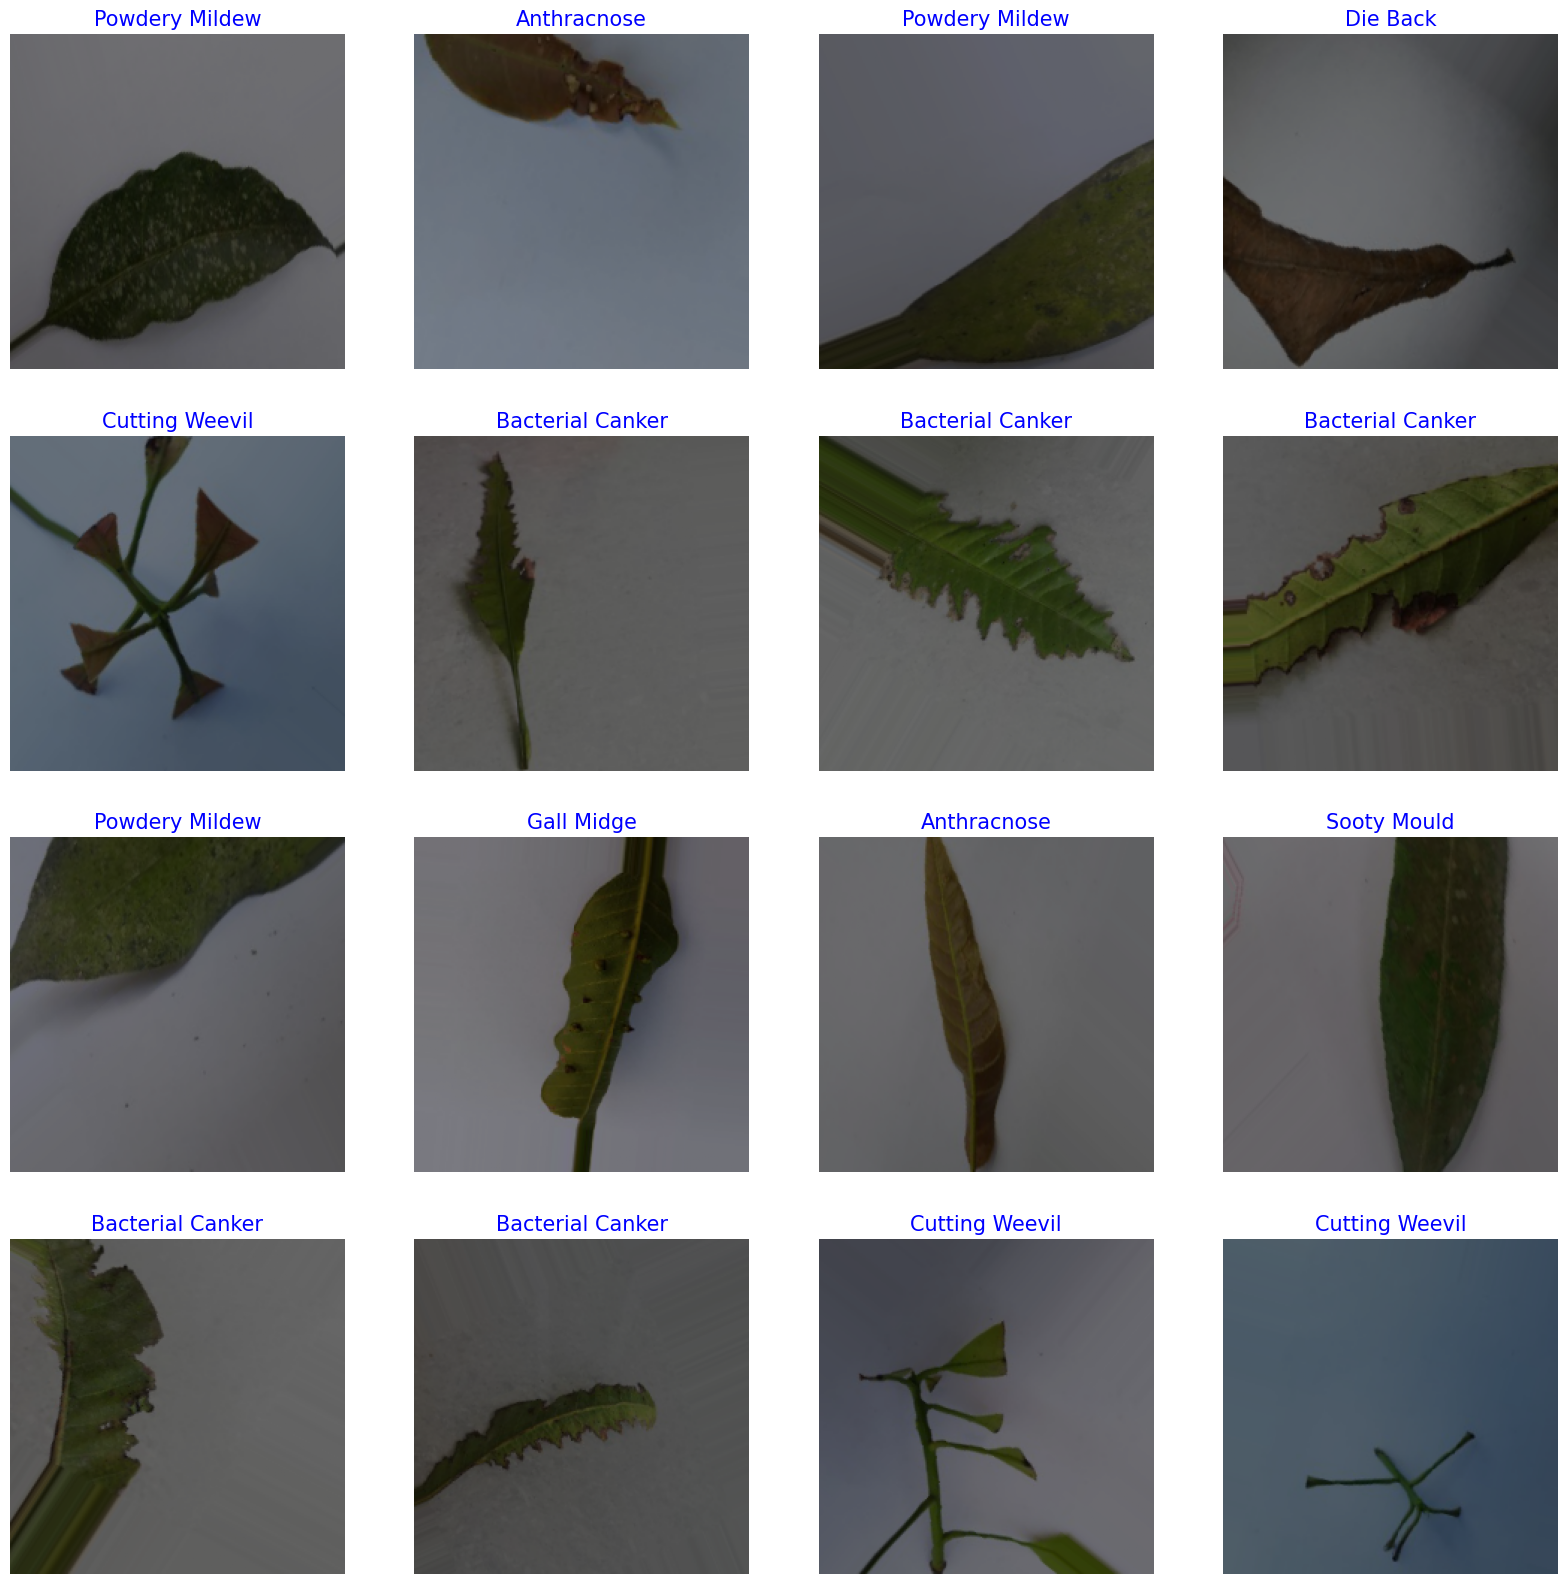

In [256]:
# Eğitim veri üreticisinin sınıf indislerini içeren bir sözlük oluşturulur.
g_dict = train_gen.class_indices  

# Sınıf adlarını içeren bir liste oluşturulur.
classes = list(g_dict.keys())       

# Eğitim veri üretecinin bir grup örneğini alınır.
images, labels = next(train_gen)      

# 20x20 büyüklüğünde bir çizim figürü oluşturulur.
plt.figure(figsize=(20, 20))  

# 16 örnek için bir döngü başlatılır.
for i in range(16):
    
    # 4x4'lük bir alt-çizim oluşturulur.
    plt.subplot(4, 4, i + 1)  
    
    # Görüntü, 0 ile 255 arasında değerler içeren bir dizi olarak normalleştirilir.
    image = images[i] / 255       
   
    # Normalleştirilmiş görüntü, alt-çizimde gösterilir.
    plt.imshow(image)  
    
    # Etiket dizisindeki en büyük değerin (1'e karşılık gelen) indeksi alınır.
    index = np.argmax(labels[i])  
    
    # İndise karşılık gelen sınıf adı alınır.
    class_name = classes[index]   
    
    # Alt-çizimin başlığı, sınıf adı olarak ayarlanır ve mavi renkte gösterilir.
    plt.title(class_name, color='blue', fontsize=15)  
    
    # Eksenler kapatılır, yani alt-çizimdeki koordinat ekseni gösterilmez.
    plt.axis('off')  
    
# Oluşturulan tüm alt-çizimleri içeren genel çizim gösterilir.
plt.show()  

In [274]:
# Model Yapısını Oluştur

# Giriş görüntü boyutları
img_size = (224, 224)

# Görüntü kanal sayısı (RGB için 3)
channels = 3

# Giriş görüntü şekli
img_shape = (img_size[0], img_size[1], channels)

# Modelin çıktı sınıf sayısını belirlemek için eğitim veri üreticisinin sınıf sayısı
class_count = len(list(train_gen.class_indices.keys()))

#EfficientNetB7 modeli yapılandırılır.
base_model = tf.keras.applications.efficientnet.EfficientNetB7(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')

# Önceden eğitilmiş modelin eğitilebilirliğini kapatma
base_model.trainable = False

# Yeni modelin oluşturulması
model = Sequential([
    base_model,  # Önceden eğitilmiş model
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),  # Batch normalization katmanı
    Dense(128, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),  # Yoğun (Dense) katman
    Dropout(rate=0.45, seed=123),   # Dropout katmanı
    Dense(class_count, activation='softmax')  # Çıkış katmanı
])

# Modelin derlenmesi
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Modelin özetini görüntüleme
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional  (None, 2560)              64097687  
 )                                                               
                                                                 
 batch_normalization_195 (B  (None, 2560)              10240     
 atchNormalization)                                              
                                                                 
 dense_13 (Dense)            (None, 128)               327808    
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 8)                 1032      
                                                                 
Total params: 64436767 (245.81 MB)
Trainable params: 3

In [259]:
!nvidia-smi

Sun Feb  4 13:12:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.33                 Driver Version: 546.33       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti   WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   61C    P0              16W /  50W |     67MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [276]:
history = model.fit(x=train_gen,
                    epochs = 50,
                    verbose = 1,
                    validation_data = valid_gen, 
                    validation_steps = None,
                    shuffle = False,
                    batch_size = 64)

Epoch 1/50
44/44 [==============================] - 574s 13s/step - loss: 3.7051 - accuracy: 0.8600 - val_loss: 3.0347 - val_accuracy: 0.9117
Epoch 2/50
44/44 [==============================] - 567s 13s/step - loss: 2.7016 - accuracy: 0.8800 - val_loss: 2.2286 - val_accuracy: 0.9350
Epoch 3/50
44/44 [==============================] - 590s 13s/step - loss: 1.9806 - accuracy: 0.9118 - val_loss: 1.6660 - val_accuracy: 0.9333
Epoch 4/50
44/44 [==============================] - 568s 13s/step - loss: 1.5233 - accuracy: 0.9189 - val_loss: 1.2803 - val_accuracy: 0.9350
Epoch 5/50
44/44 [==============================] - 547s 12s/step - loss: 1.2859 - accuracy: 0.9104 - val_loss: 1.0915 - val_accuracy: 0.9333
Epoch 6/50
44/44 [==============================] - 550s 13s/step - loss: 1.0694 - accuracy: 0.9221 - val_loss: 0.9209 - val_accuracy: 0.9433
Epoch 7/50
44/44 [==============================] - 553s 13s/step - loss: 0.9942 - accuracy: 0.9161 - val_loss: 0.8408 - val_accuracy: 0.9517
Epoch 

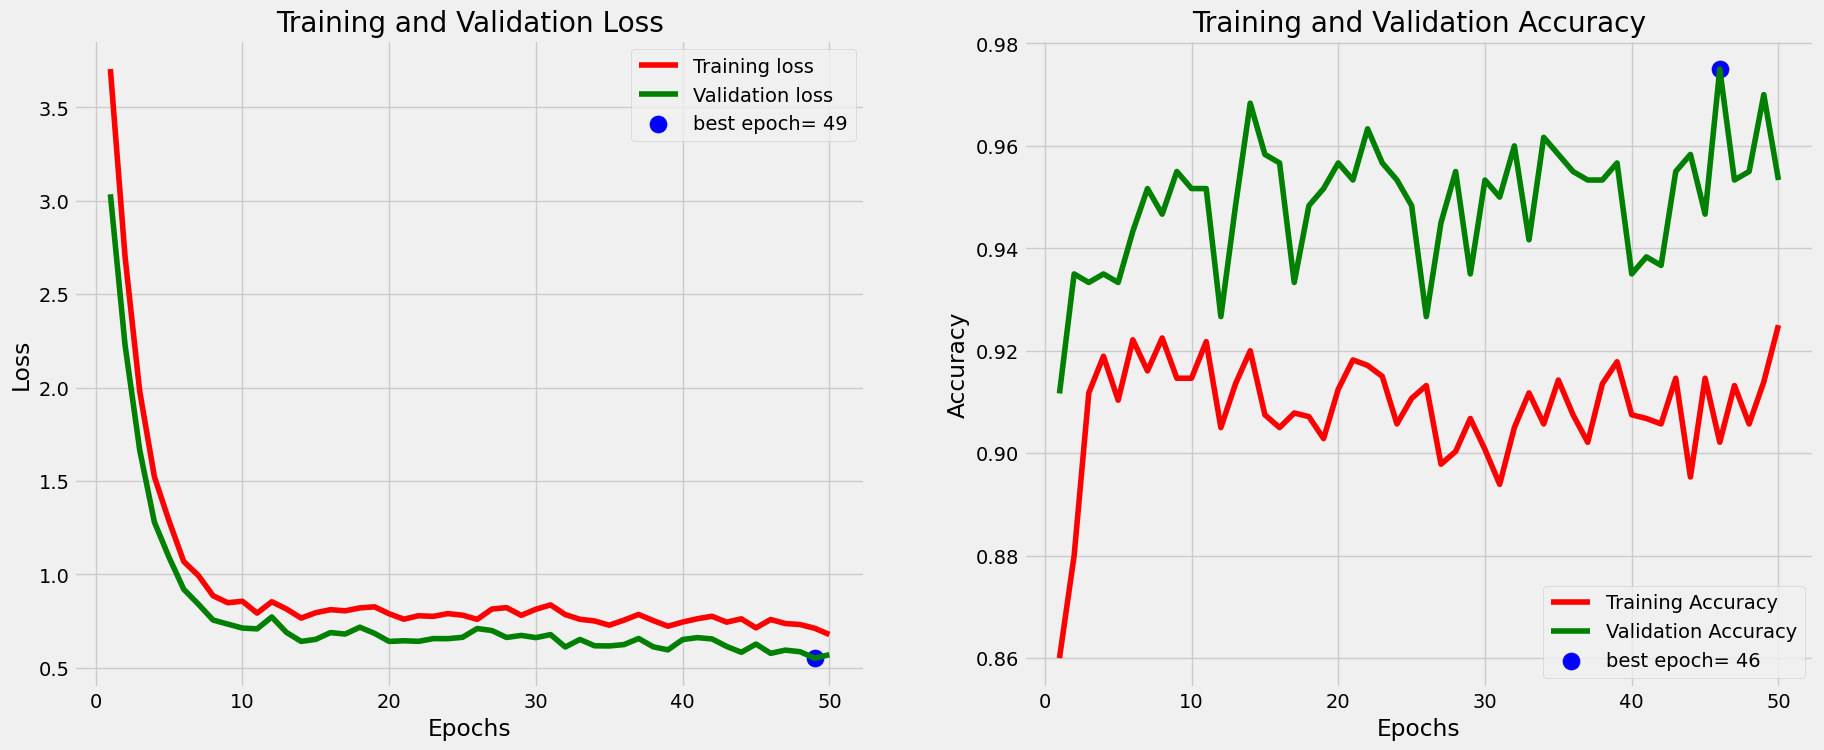

In [281]:
# Gerekli Değişkenleri Tanımla
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Eğitim Geçmişini Çiz (Plot training history)

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [282]:
train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss(Eğitim Kaybı): ", train_score[0])
print("Train Accuary(Eğitim Doğruluğu): ", train_score[1])
print('-' * 20)
print("Doğrulama Kaybı(Validation Loss): ", valid_score[0])
print("Doğrulama Başarısı(Validation Accuracy): ", valid_score[1])
print('-' * 20)
print("Test Kaybı(Test Loss): ", test_score[0])
print("Test Başarısı(Test Accuracy): ", test_score[1])

8/8 [==============================] - 97s 12s/step - loss: 0.5909 - accuracy: 0.9417
Train Loss(Eğitim Kaybı):  0.5609564781188965
Train Accuary(Eğitim Doğruluğu):  0.955078125
--------------------
Doğrulama Kaybı(Validation Loss):  0.582381010055542
Doğrulama Başarısı(Validation Accuracy):  0.951171875
--------------------
Test Kaybı(Test Loss):  0.590857982635498
Test Başarısı(Test Accuracy):  0.9416666626930237


In [463]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

8/8 [==============================] - 110s 13s/step


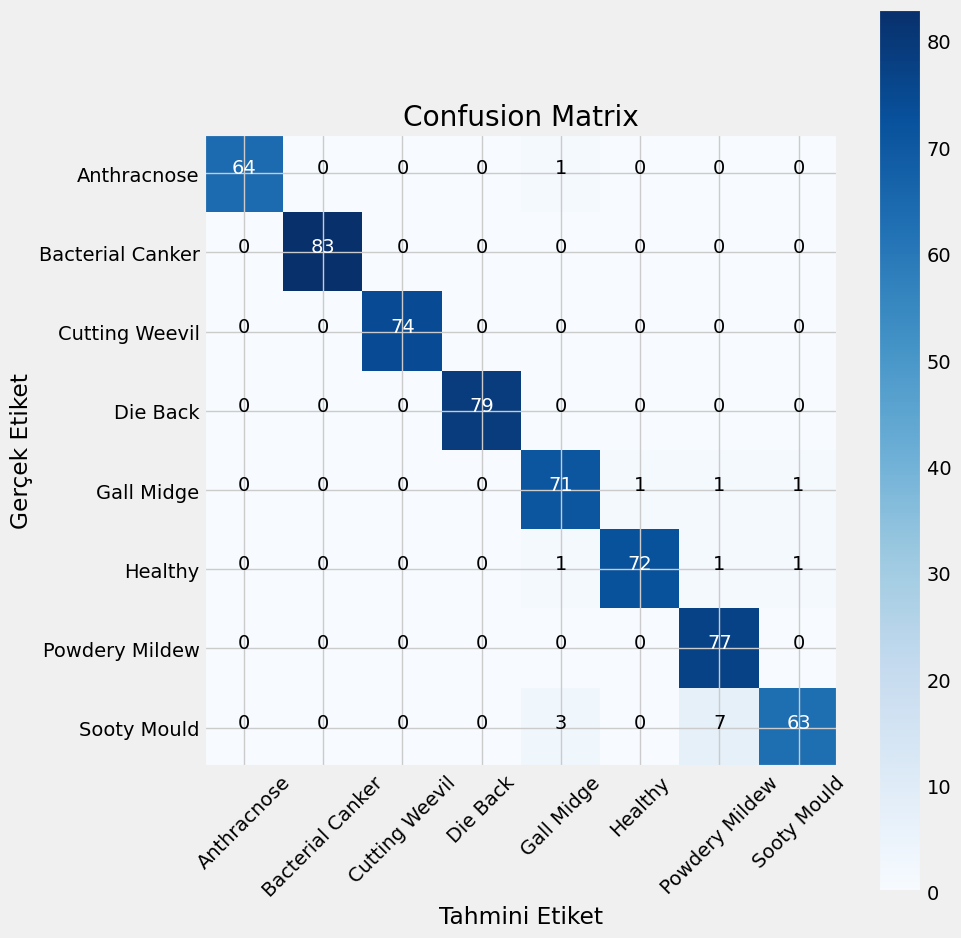

In [464]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Karışıklık Matrisi
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('Gerçek Etiket')
plt.xlabel('Tahmini Etiket')

plt.show()

In [289]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                  precision    recall  f1-score   support

     Anthracnose       0.97      0.94      0.95        65
Bacterial Canker       0.99      1.00      0.99        83
  Cutting Weevil       1.00      1.00      1.00        74
        Die Back       0.99      0.99      0.99        79
      Gall Midge       0.93      0.96      0.95        74
         Healthy       0.97      0.95      0.96        75
  Powdery Mildew       0.92      0.99      0.95        77
     Sooty Mould       0.99      0.92      0.95        73

        accuracy                           0.97       600
       macro avg       0.97      0.97      0.97       600
    weighted avg       0.97      0.97      0.97       600



In [217]:
fit_model.history['accuracy'][-1]

0.9690818190574646

In [291]:
model.save_weights('EfficientNetB7_model_weights.h5')

1/1 [==============================] - 0s 319ms/step


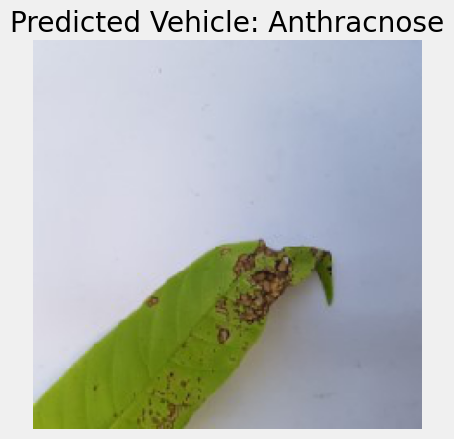

In [307]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

def predict_and_display(image_path, model, class_labels):
    
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    
    predicted_class_label = class_labels[predicted_class_index]
    
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted Vehicle: {predicted_class_label}")
    plt.show()

# Eğitilmiş modeli yüklüyoruz.
model.load_weights(r'C:\Users\batuh\ESEN_ML/EfficientNetB7_model_weights.h5')

# Sınıf etiketlerini tanımlıyoruz
class_labels = list(train_gen.class_indices.keys())


image_path_to_test = 'C:\\Users\\batuh\\ESEN_ML/Mango Folder/MangoLeafBD Dataset\\Anthracnose\\20211011_165905 (Custom).jpg'

predict_and_display(image_path_to_test, model, class_labels)

In [310]:
import psycopg2
from psycopg2 import OperationalError

In [401]:

def create_connection(db_name, db_user, db_password, db_host, db_port):
    connection = None
    try:
        connection = psycopg2.connect(
            database=db_name,
            user=db_user,
            password=db_password,
            host=db_host,
            port=db_port
        )
        print("Bağlantı başarılı")
    except OperationalError as e:
        print(f"Hata: {e}")
    return connection
def execute_query(connection, query):
    connection.autocommit = True
    cursor = connection.cursor()
    try:
        cursor.execute(query)
        print("Sorgu başarıyla çalıştırıldı")
    except OperationalError as e:
        print(f"Hata: {e}")
# Veritabanı bilgileriniz
db_name = "ESENml"
db_user = "postgres"  # Kullanıcı adınız
db_password = "your_pass"  # Şifreniz
db_host = "localhost"  # Veritabanı sunucusunun adresi
db_port = "5432"  # PostgreSQL'in çalıştığı port numarası

# Veritabanı bağlantısı oluştur
conn = create_connection(db_name, db_user, db_password, db_host, db_port)

# Sorgu metnini yaz
query = """ INSERT INTO "Models" (model_name) VALUES ('EfficientNetB7')"""

# Sorguyu çalıştır
execute_query(conn, query)


conn.commit()
cur.close()
conn.close()

Bağlantı başarılı
Sorgu başarıyla çalıştırıldı


In [400]:
def calculate_tp_tn_fp_fn(conf_matrix, class_labels):
    num_classes = conf_matrix.shape[0]
    tp_tn_fp_fn_dict = {}

    for i, class_label in enumerate(class_labels):
        tp = conf_matrix[i][i]
        fp = conf_matrix[:, i].sum() - tp
        fn = conf_matrix[i, :].sum() - tp
        tn = conf_matrix.sum() - (fp + fn + tp)
        tp_tn_fp_fn_dict[class_label] = {'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn}

    return tp_tn_fp_fn_dict

# Örnek confusion matr

# Calculate TP, FP, FN, and TN for each class with class labels
results = calculate_tp_tn_fp_fn(cm, classes)

for class_label in results:
    print(f"{class_label}: {results[class_label]}")


Anthracnose: {'TP': 61, 'FP': 2, 'FN': 4, 'TN': 533}
Bacterial Canker: {'TP': 83, 'FP': 1, 'FN': 0, 'TN': 516}
Cutting Weevil: {'TP': 74, 'FP': 0, 'FN': 0, 'TN': 526}
Die Back: {'TP': 78, 'FP': 1, 'FN': 1, 'TN': 520}
Gall Midge: {'TP': 71, 'FP': 5, 'FN': 3, 'TN': 521}
Healthy: {'TP': 71, 'FP': 2, 'FN': 4, 'TN': 523}
Powdery Mildew: {'TP': 76, 'FP': 7, 'FN': 1, 'TN': 516}
Sooty Mould: {'TP': 67, 'FP': 1, 'FN': 6, 'TN': 526}


In [406]:
conn = create_connection(db_name, db_user, db_password, db_host, db_port)

def insert_class_metrics(conn, data_dict):
    with conn.cursor() as cursor:
        for class_name, metrics in data_dict.items():
            # numpy.int64 türündeki verileri Python'un yerel int türüne dönüştür
            tp = int(metrics['TP'])
            fp = int(metrics['FP'])
            fn = int(metrics['FN'])
            tn = int(metrics['TN'])

            cursor.execute("""
                INSERT INTO "Soru1b"(model_id, true_positive, false_positive, false_negative, true_negative, class_name) 
                VALUES (%s, %s, %s, %s, %s, %s)
            """, (3, tp, fp, fn, tn, class_name))
        conn.commit()

insert_class_metrics(conn, results)  # results, metriklerinizi içeren sözlüğünüz

# Cursor'u ve bağlantıyı kapat
conn.close()


Bağlantı başarılı


In [441]:
conn = create_connection(db_name, db_user, db_password, db_host, db_port)

tp = int(cmkmeans[0][0])
fp = int(cmkmeans[0][1])
fn = int(cmkmeans[1][0])
tn = int(cmkmeans[1][1])
class_km = 'Unhealthy'

query = f"""
    INSERT INTO "Soru1a"(model_id, true_positive, false_positive, false_negative, true_negative, class_name) 
    VALUES ({4}, {tp}, {fp}, {fn}, {tn}, '{class_km}')
"""

execute_query(conn, query)

conn.commit()
conn.close()


Bağlantı başarılı
Sorgu başarıyla çalıştırıldı


In [414]:
cmkmeans

array([[ 63,  37],
       [199, 501]], dtype=int64)

In [418]:
cmkmeans[1][0]

199

# VGG16 Model

In [444]:
img_shape = (img_size[0], img_size[1], channels)

base_model2 = tf.keras.applications.VGG16(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')

58889256/58889256 [==============================] - 9s 0us/step


In [445]:
base_model2.trainable = False

In [449]:
model_vgg = Sequential([
    base_model2,
    BatchNormalization(),
    Dense(128, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate=0.45, seed=123),   
    Dense(class_count, activation='softmax') 

])

model_vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_vgg.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 batch_normalization_197 (B  (None, 512)               2048      
 atchNormalization)                                              
                                                                 
 dense_17 (Dense)            (None, 128)               65664     
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_18 (Dense)            (None, 8)                 1032      
                                                                 
Total params: 14783432 (56.39 MB)
Trainable params: 67720 (264.53 KB)
Non-trainable params: 14715712 (56.14 MB)
________

In [451]:
history2 = model_vgg.fit(x=train_gen,
                    epochs = 10,
                    verbose = 1,
                    validation_data = valid_gen, 
                    validation_steps = None,
                    shuffle = False,
                    batch_size = 64)

Epoch 1/10
44/44 [==============================] - 441s 10s/step - loss: 4.5150 - accuracy: 0.6164 - val_loss: 3.8017 - val_accuracy: 0.8183
Epoch 2/10
44/44 [==============================] - 454s 10s/step - loss: 3.0314 - accuracy: 0.8725 - val_loss: 2.5137 - val_accuracy: 0.9367
Epoch 3/10
44/44 [==============================] - 447s 10s/step - loss: 2.2273 - accuracy: 0.9089 - val_loss: 1.8095 - val_accuracy: 0.9550
Epoch 4/10
44/44 [==============================] - 452s 10s/step - loss: 1.6308 - accuracy: 0.9354 - val_loss: 1.3241 - val_accuracy: 0.9633
Epoch 5/10
44/44 [==============================] - 463s 11s/step - loss: 1.2141 - accuracy: 0.9489 - val_loss: 0.9980 - val_accuracy: 0.9700
Epoch 6/10
44/44 [==============================] - 455s 10s/step - loss: 0.9297 - accuracy: 0.9564 - val_loss: 0.7714 - val_accuracy: 0.9633
Epoch 7/10
44/44 [==============================] - 465s 11s/step - loss: 0.7459 - accuracy: 0.9593 - val_loss: 0.6232 - val_accuracy: 0.9767
Epoch 

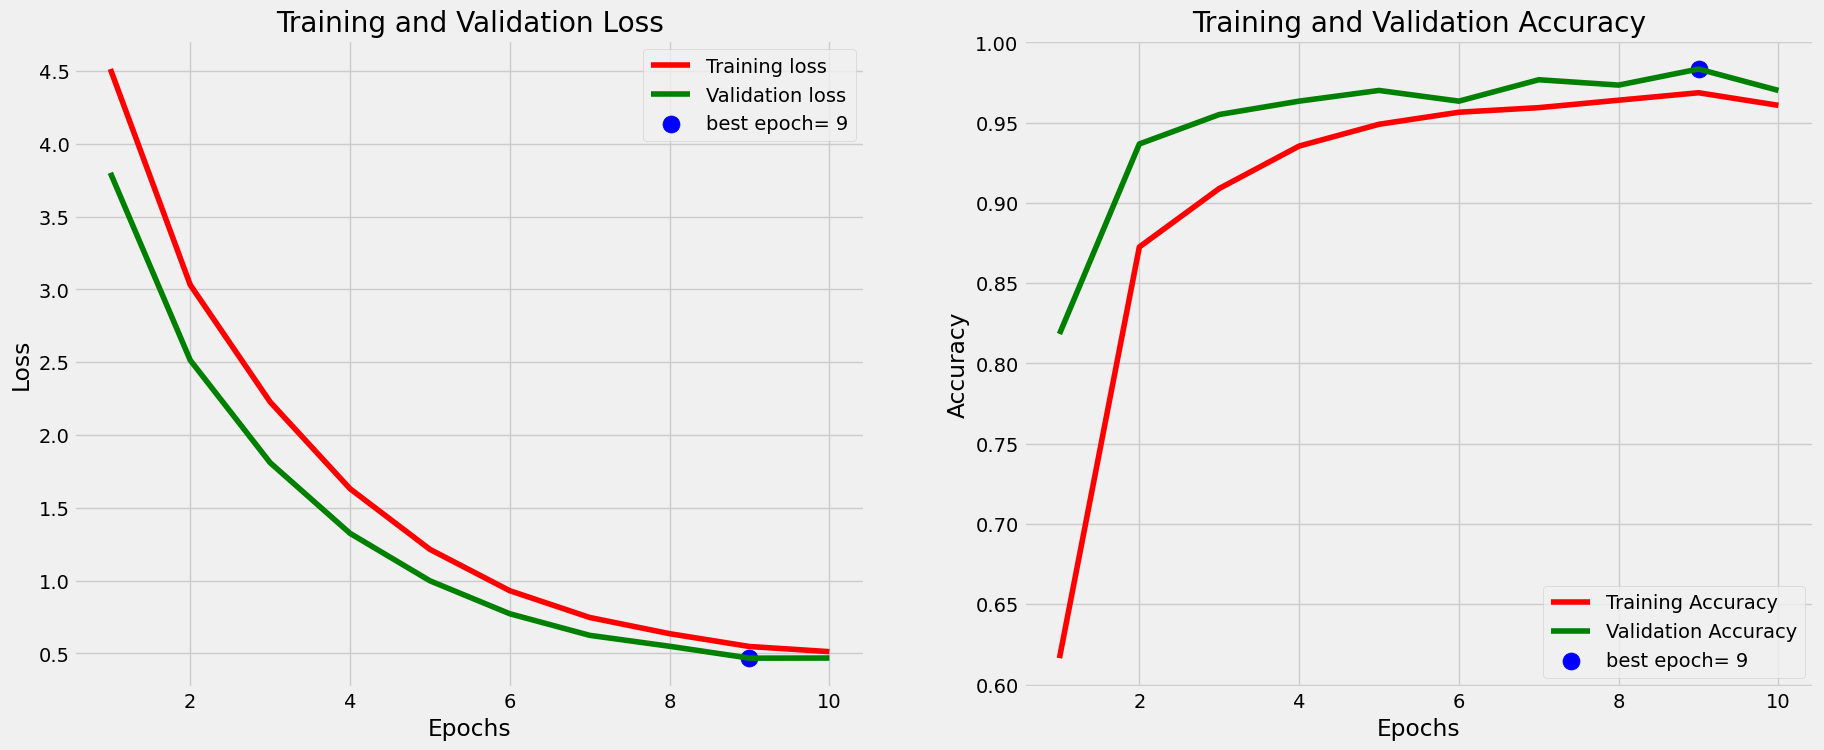

In [452]:
# Gerekli Değişkenleri Tanımla
tr_acc = history2.history['accuracy']
tr_loss = history2.history['loss']
val_acc = history2.history['val_accuracy']
val_loss = history2.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Eğitim Geçmişini Çiz (Plot training history)

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [454]:
train_score2 = model_vgg.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score2 = model_vgg.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score2 = model_vgg.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss(Eğitim Kaybı): ", train_score2[0])
print("Train Accuary(Eğitim Doğruluğu): ", train_score2[1])
print('-' * 20)
print("Doğrulama Kaybı(Validation Loss): ", valid_score2[0])
print("Doğrulama Başarısı(Validation Accuracy): ", valid_score2[1])
print('-' * 20)
print("Test Kaybı(Test Loss): ", test_score2[0])
print("Test Başarısı(Test Accuracy): ", test_score2[1])

8/8 [==============================] - 82s 10s/step - loss: 0.4346 - accuracy: 0.9817
Train Loss(Eğitim Kaybı):  0.44099435210227966
Train Accuary(Eğitim Doğruluğu):  0.974609375
--------------------
Doğrulama Kaybı(Validation Loss):  0.45666933059692383
Doğrulama Başarısı(Validation Accuracy):  0.970703125
--------------------
Test Kaybı(Test Loss):  0.4346189498901367
Test Başarısı(Test Accuracy):  0.9816666841506958


In [455]:
preds2 = model_vgg.predict(test_gen)
y_pred2 = np.argmax(preds, axis=1)

8/8 [==============================] - 77s 10s/step


In [479]:
cm2 = confusion_matrix(test_gen.classes, y_pred2);cm2

array([[61,  0,  0,  0,  3,  1,  0,  0],
       [ 0, 83,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 74,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 78,  0,  0,  1,  0],
       [ 1,  0,  0,  1, 71,  0,  1,  0],
       [ 1,  1,  0,  0,  2, 71,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 76,  1],
       [ 0,  0,  0,  0,  0,  1,  5, 67]], dtype=int64)

In [467]:
model_vgg.save_weights('VGG16_model_weights.h5')

In [470]:
results2 = calculate_tp_tn_fp_fn(cm2, classes);results2

{'Anthracnose': {'TP': 61, 'FP': 2, 'FN': 4, 'TN': 533},
 'Bacterial Canker': {'TP': 83, 'FP': 1, 'FN': 0, 'TN': 516},
 'Cutting Weevil': {'TP': 74, 'FP': 0, 'FN': 0, 'TN': 526},
 'Die Back': {'TP': 78, 'FP': 1, 'FN': 1, 'TN': 520},
 'Gall Midge': {'TP': 71, 'FP': 5, 'FN': 3, 'TN': 521},
 'Healthy': {'TP': 71, 'FP': 2, 'FN': 4, 'TN': 523},
 'Powdery Mildew': {'TP': 76, 'FP': 7, 'FN': 1, 'TN': 516},
 'Sooty Mould': {'TP': 67, 'FP': 1, 'FN': 6, 'TN': 526}}

In [471]:
conn = create_connection(db_name, db_user, db_password, db_host, db_port)

def insert_class_metrics(conn, data_dict):
    with conn.cursor() as cursor:
        for class_name, metrics in data_dict.items():
            # numpy.int64 türündeki verileri Python'un yerel int türüne dönüştür
            tp = int(metrics['TP'])
            fp = int(metrics['FP'])
            fn = int(metrics['FN'])
            tn = int(metrics['TN'])

            cursor.execute("""
                INSERT INTO "Soru1b"(model_id, true_positive, false_positive, false_negative, true_negative, class_name) 
                VALUES (%s, %s, %s, %s, %s, %s)
            """, (5, tp, fp, fn, tn, class_name))
        conn.commit()

insert_class_metrics(conn, results2)  # results, metriklerinizi içeren sözlüğünüz

# Cursor'u ve bağlantıyı kapat
conn.close()


Bağlantı başarılı


# ResNet50

In [474]:
base_model3 = tf.keras.applications.ResNet50(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')

base_model3.trainable = False

model3 = Sequential([
    base_model3,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(128, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model3.compile(optimizer= 'adam', loss= 'categorical_crossentropy', metrics= ['accuracy'])

model3.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 batch_normalization_200 (B  (None, 2048)              8192      
 atchNormalization)                                              
                                                                 
 dense_23 (Dense)            (None, 128)               262272    
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                                 
 dense_24 (Dense)            (None, 8)                 1032      
                                                                 
Total params: 23859208 (91.02 MB)
Trainable params: 267400 (1.02 MB)
Non-trainable params: 23591808 (90.00 MB)
________

In [475]:
history3 = model3.fit(x=train_gen,
                    epochs = 10,
                    verbose = 1,
                    validation_data = valid_gen, 
                    validation_steps = None,
                    shuffle = False,
                    batch_size = 64)

Epoch 1/10
44/44 [==============================] - 198s 4s/step - loss: 4.4335 - accuracy: 0.8250 - val_loss: 3.6990 - val_accuracy: 0.9500
Epoch 2/10
44/44 [==============================] - 186s 4s/step - loss: 2.7877 - accuracy: 0.9511 - val_loss: 2.2072 - val_accuracy: 0.9733
Epoch 3/10
44/44 [==============================] - 191s 4s/step - loss: 1.7599 - accuracy: 0.9700 - val_loss: 1.3623 - val_accuracy: 0.9800
Epoch 4/10
44/44 [==============================] - 174s 4s/step - loss: 1.1493 - accuracy: 0.9754 - val_loss: 0.9083 - val_accuracy: 0.9850
Epoch 5/10
44/44 [==============================] - 177s 4s/step - loss: 0.8108 - accuracy: 0.9807 - val_loss: 0.6555 - val_accuracy: 0.9900
Epoch 6/10
44/44 [==============================] - 178s 4s/step - loss: 0.6478 - accuracy: 0.9804 - val_loss: 0.5541 - val_accuracy: 0.9817
Epoch 7/10
44/44 [==============================] - 174s 4s/step - loss: 0.5612 - accuracy: 0.9757 - val_loss: 0.4820 - val_accuracy: 0.9883
Epoch 8/10
44

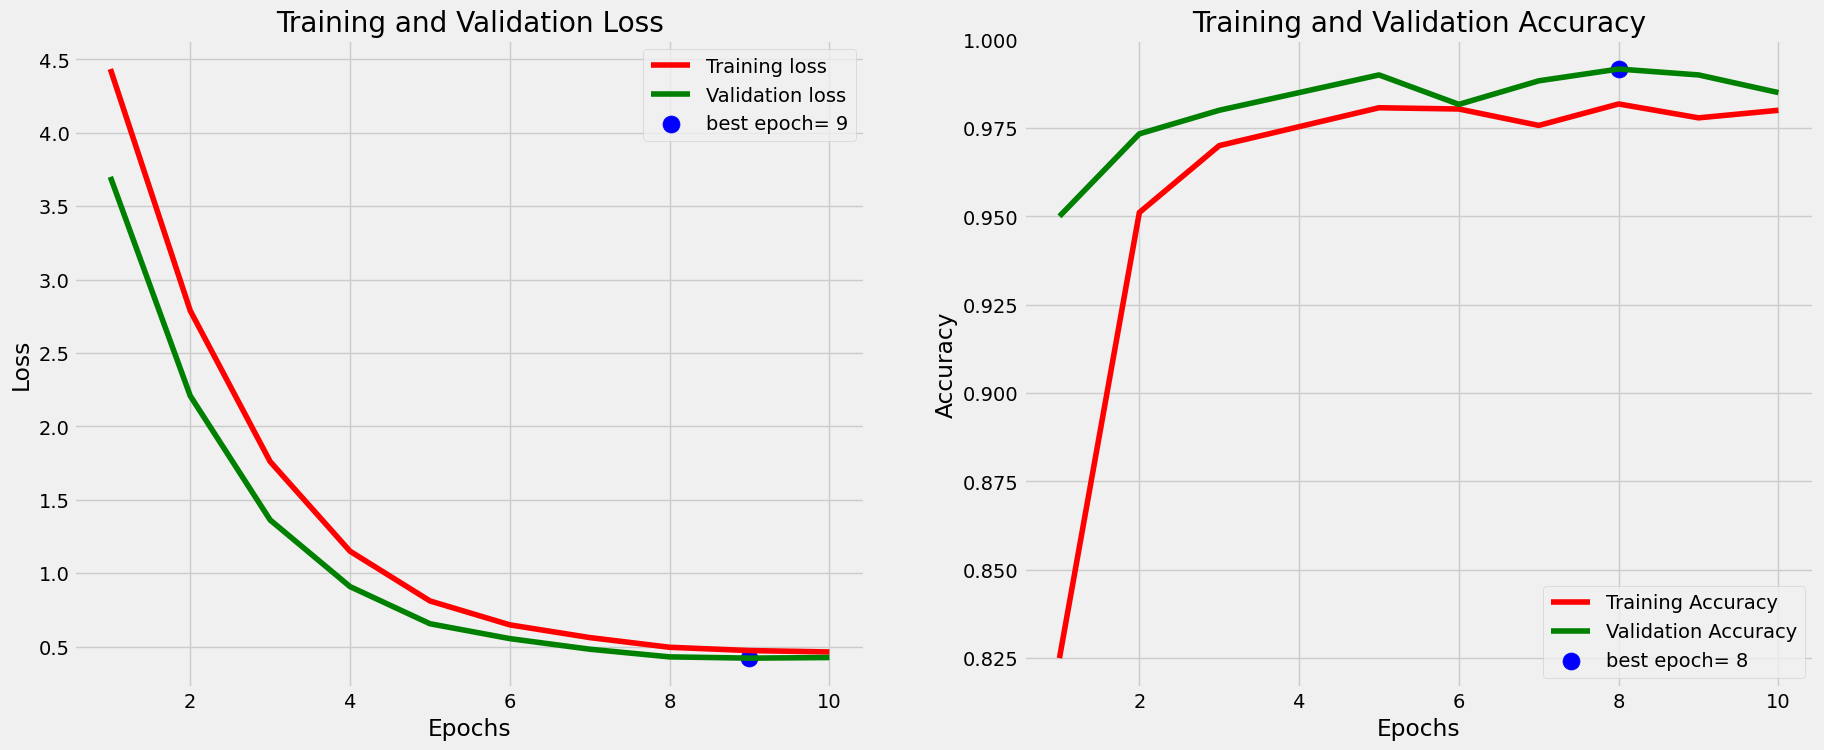

In [476]:
# Gerekli Değişkenleri Tanımla
tr_acc = history3.history['accuracy']
tr_loss = history3.history['loss']
val_acc = history3.history['val_accuracy']
val_loss = history3.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Eğitim Geçmişini Çiz (Plot training history)

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [477]:
preds3 = model3.predict(test_gen)
y_pred3 = np.argmax(preds3, axis=1)

8/8 [==============================] - 32s 4s/step


In [478]:
cm3 = confusion_matrix(test_gen.classes, y_pred3); cm3

array([[64,  1,  0,  0,  0,  0,  0,  0],
       [ 0, 83,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 74,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 79,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 72,  2,  0,  0],
       [ 0,  0,  0,  0,  0, 75,  0,  0],
       [ 0,  0,  0,  1,  0,  0, 75,  1],
       [ 0,  0,  0,  0,  0,  0,  0, 73]], dtype=int64)

In [480]:
model3.save_weights('ResNet50_model_weights.h5')

In [481]:
results3 = calculate_tp_tn_fp_fn(cm3, classes)

conn = create_connection(db_name, db_user, db_password, db_host, db_port)

def insert_class_metrics(conn, data_dict):
    with conn.cursor() as cursor:
        for class_name, metrics in data_dict.items():
            # numpy.int64 türündeki verileri Python'un yerel int türüne dönüştür
            tp = int(metrics['TP'])
            fp = int(metrics['FP'])
            fn = int(metrics['FN'])
            tn = int(metrics['TN'])

            cursor.execute("""
                INSERT INTO "Soru1b"(model_id, true_positive, false_positive, false_negative, true_negative, class_name) 
                VALUES (%s, %s, %s, %s, %s, %s)
            """, (6, tp, fp, fn, tn, class_name))
        conn.commit()

insert_class_metrics(conn, results3)  # results, metriklerinizi içeren sözlüğünüz

# Cursor'u ve bağlantıyı kapat
conn.close()


Bağlantı başarılı


In [482]:
fit_model.history['accuracy'][-1]

0.9690818190574646

In [486]:
history2.history['accuracy'][-1]

0.9607142806053162

In [487]:
history3.history['accuracy'][-1]

0.9800000190734863